线性回归

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [2]:
# 创建示例数据集
data = {
    "0": [2, 3, 4, 5, 6],
    "X": [1, 2, 3, 4, 5],
    "1": [5, 4, 3, 2, 1],
    "2": [1, 2, 3, 4, 5],
    "Y": [3, 4, 2, 5, 6]
}

# 将数据集转换为 DataFrame
dataset = pd.DataFrame(data)

def Squared_term(dataset, variables):
    for var in variables:
        dataset[f'{var}_squared_term'] = dataset[var] ** 2
    return dataset

def Interaction_term(dataset, variables):
    for i in range(len(variables)):
        for j in range(i + 1, len(variables)):
            dataset[f'{variables[i]}_{variables[j]}'] = dataset[variables[i]] * dataset[variables[j]]
    return dataset

In [3]:
variables = dataset.columns.drop(["X", "Y"]).tolist()
model1_features = ["X"] + variables
d1 = Squared_term(dataset[model1_features], variables)
d1 = Interaction_term(d1, variables)
model1_features = ["X"] + variables + [f'{var}_squared_term' for var in variables]
print(model1_features)
model1_features = d1.columns.tolist()
print(model1_features)

['X', '0', '1', '2', '0_squared_term', '1_squared_term', '2_squared_term']
['X', '0', '1', '2', '0_squared_term', '1_squared_term', '2_squared_term', '0_1', '0_2', '1_2']


In [4]:
scaler = StandardScaler()
d1_scaled = scaler.fit_transform(d1)
model1 = LinearRegression().fit(d1_scaled, dataset[["Y"]])
model1_coefs = model1.coef_[0].tolist()
model1_dict = {name: coef for name, coef in zip(model1_features, model1_coefs)}
print(model1_dict)

{'X': 0.08959372776926722, '0': 0.08959372776926722, '1': -0.0895937277692671, '2': 0.0895937277692671, '0_squared_term': 0.13368279918203282, '1_squared_term': -0.028323816801206637, '2_squared_term': 0.1474778756831382, '0_1': -0.2930171810439319, '0_2': 0.13966211127148917, '1_2': -0.3079290260806433}


In [4]:
# 将 X 放到第一列
variables.remove("X")
variables = ["X"] + variables

In [5]:
model = LinearRegression().fit(dataset[variables], dataset[["Y"]])
coefs = model.coef_[0].tolist()
names = model.feature_names_in_.tolist()
variables.remove("X")

In [6]:
df = []
for i, variable in enumerate(variables):
    for j, name in enumerate(names):
        if variable == name:
            df.append({
                "variable": variable,
                "v~Y_coefficient": coefs[j],
            })
    
df = pd.DataFrame(df)
df
# df["dataset"] = dataset.name

,variable,v~Y_coefficient
0,0,0.233333
1,1,-0.233333


In [7]:
df["X~Y_coefficient"] = coefs[0]

# # Reorder columns:
# df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

In [8]:
df

,variable,v~Y_coefficient,X~Y_coefficient
0,0,0.233333,0.233333
1,1,-0.233333,0.233333


岭回归

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import crunch
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>


In [3]:
X_train, y_train, X_test = crunch.load_data()

download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exists: file length match


In [4]:
def ridge_regression_feature(dataset):
    variables = dataset.columns.drop(["X", "Y"]).tolist()
    param_grid = {'alpha': np.logspace(-6, 6, 13)}
    
    # model1: Fit X, v ~ Y
    model1_features = ["X"] + variables
    scaler1 = StandardScaler()
    d1_scaled = scaler1.fit_transform(dataset[model1_features])
    model1 = GridSearchCV(Ridge(random_state=42), param_grid, cv=5)
    model1.fit(d1_scaled, dataset["Y"])
    model1_coefs = model1.best_estimator_.coef_.tolist()
    model1_dict = {name: coef for name, coef in zip(model1_features, model1_coefs)}
    
    # model2: Fit v ~ X
    model2_features = variables
    scaler2 = StandardScaler()
    d2_scaled = scaler2.fit_transform(dataset[model2_features])
    model2 = GridSearchCV(Ridge(random_state=42), param_grid, cv=5)
    model2.fit(d2_scaled, dataset["X"])
    model2_coefs = model2.best_estimator_.coef_.tolist()
    model2_dict = {name: coef for name, coef in zip(model2_features, model2_coefs)}
    
    df = []
    for i, variable in enumerate(variables):
        df.append({
            "variable": variable,
            "v~Y_ridge_coefficient": model1_dict[variable],
            "v~X_ridge_coefficient": model2_dict[variable]
        })
        
    df = pd.DataFrame(df)
    # df["dataset"] = dataset.name
    
    df["X~Y_ridge_coefficient"] = model1_dict["X"]
    
    # Reorder columns:
    # df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    # 获取最优的 alpha 值
    best_alpha_model1 = model1.best_params_['alpha']
    best_alpha_model2 = model2.best_params_['alpha']

    return df, best_alpha_model1, best_alpha_model2

In [5]:
alpha_model1 = []
alpha_model2 = []
from tqdm import tqdm
count = 0

for key, df in tqdm(X_train.items(), total=len(X_train), desc="Processing datasets"):
    df, best_alpha_model1, best_alpha_model2 = ridge_regression_feature(df)
    alpha_model1.append(best_alpha_model1)
    alpha_model2.append(best_alpha_model2)
    count+=1
    if count == 2000:
        break

Processing datasets:   9%|▊         | 1999/23500 [06:01<1:04:48,  5.53it/s]


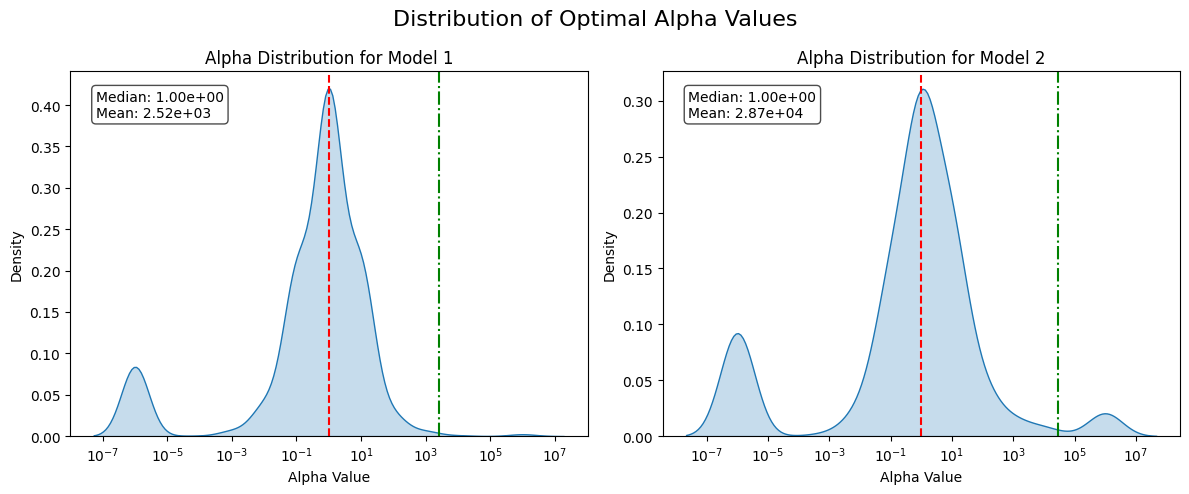

In [6]:
def plot_alpha_distributions(alpha_model1, alpha_model2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Distribution of Optimal Alpha Values', fontsize=16)

    for ax, data, title in zip([ax1, ax2], [alpha_model1, alpha_model2], ['Model 1', 'Model 2']):
        sns.kdeplot(data, ax=ax, log_scale=True, fill=True)
        ax.set_title(f'Alpha Distribution for {title}')
        ax.set_xlabel('Alpha Value')
        ax.set_ylabel('Density')

        # 添加统计信息
        median = np.median(data)
        mean = np.mean(data)
        ax.axvline(median, color='r', linestyle='--', label=f'Median: {median:.2e}')
        ax.axvline(mean, color='g', linestyle='-.', label=f'Mean: {mean:.2e}')
        
        # 添加文本注释
        ax.text(0.05, 0.95, f'Median: {median:.2e}\nMean: {mean:.2e}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()

# 调用函数
plot_alpha_distributions(alpha_model1, alpha_model2)

聚类特征

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd

In [2]:
def enhanced_cluster_features(dataset):
    variables = dataset.columns.drop(["X", "Y"]).tolist()
    scaler = StandardScaler()
    d_scaled = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

    results = []
    eps_values = [0.3, 0.5, 0.7]
    
    for variable in variables:
        cluster_counts = []
        noise_counts = []
        avg_cluster_sizes = []
        density_variations = []
        feature_importances = []
        silhouette_scores = []
        
        for eps in eps_values:
            cluster_df = d_scaled[[variable, "X", "Y"]].copy()
            dbscan = DBSCAN(eps=eps, min_samples=5)
            cluster_df["cluster"] = dbscan.fit_predict(cluster_df)
            
            # 基本统计
            cluster_count = len(set(cluster_df["cluster"])) - (1 if -1 in cluster_df["cluster"] else 0)
            noise_count = (cluster_df["cluster"] == -1).sum()
            cluster_counts.append(cluster_count)
            noise_counts.append(noise_count)
            
            # 密度分析
            cluster_sizes = cluster_df[cluster_df["cluster"] != -1]["cluster"].value_counts()
            avg_cluster_size = cluster_sizes.mean() if not cluster_sizes.empty else 0
            density_variation = cluster_sizes.std() / avg_cluster_size if avg_cluster_size > 0 else 0
            avg_cluster_sizes.append(avg_cluster_size)
            density_variations.append(density_variation)
            
            # 特征重要性
            if cluster_count > 1:  # 确保有多个簇
                feature_importance = abs(np.corrcoef(cluster_df[variable], cluster_df["cluster"]))[0, 1]
            else:
                feature_importance = 0
            feature_importances.append(feature_importance)
            
            # 轮廓系数
            non_noise_mask = cluster_df["cluster"] != -1
            if len(set(cluster_df.loc[non_noise_mask, "cluster"])) > 1:
                sil_score = silhouette_score(cluster_df.loc[non_noise_mask, [variable, "X", "Y"]], 
                                             cluster_df.loc[non_noise_mask, "cluster"], 
                                             metric="euclidean")
            else:
                sil_score = 0
            silhouette_scores.append(sil_score)
        
        result = {
            "variable": variable
        }
        for i, eps in enumerate(eps_values):
            result.update({
                f"cluster_count_{eps}": cluster_counts[i],
                f"noise_count_{eps}": noise_counts[i],
                f"avg_cluster_size_{eps}": avg_cluster_sizes[i],
                f"density_variation_{eps}": density_variations[i],
                f"feature_importance_{eps}": feature_importances[i],
                f"silhouette_score_{eps}": silhouette_scores[i]
            })
        results.append(result)

    df = pd.DataFrame(results)
    # df["dataset"] = dataset.name

    # # Reorder columns:
    # df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

In [3]:
# 创建示例数据集
data = {
    "0": [2, 3, 4, 5, 6],
    "X": [1, 2, 3, 4, 5],
    "1": [5, 4, 3, 2, 1],
    "2": [1, 2, 3, 4, 5],
    "Y": [3, 4, 2, 5, 6]
}

# 将数据集转换为 DataFrame
dataset = pd.DataFrame(data)
print(dataset)

   0  X  1  2  Y
0  2  1  5  1  3
1  3  2  4  2  4
2  4  3  3  3  2
3  5  4  2  4  5
4  6  5  1  5  6


In [4]:
df = enhanced_cluster_features(dataset)
print(df)

  variable  cluster_count_0.3  noise_count_0.3  avg_cluster_size_0.3  \
0        0                  1                5                     0   
1        1                  1                5                     0   
2        2                  1                5                     0   

   density_variation_0.3  feature_importance_0.3  silhouette_score_0.3  \
0                      0                       0                     0   
1                      0                       0                     0   
2                      0                       0                     0   

   cluster_count_0.5  noise_count_0.5  avg_cluster_size_0.5  \
0                  1                5                     0   
1                  1                5                     0   
2                  1                5                     0   

   density_variation_0.5  feature_importance_0.5  silhouette_score_0.5  \
0                      0                       0                     0   
1            

PC

In [1]:
import numpy as np
import pandas as pd
from pgmpy.estimators import PC
from pgmpy.independencies import Independencies

In [2]:
import crunch
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exist

In [3]:
# 数据预处理函数
def preprocess_data(data):
    # 确保数据是浮点型
    data = data.astype(float)
    # 替换无穷大值为NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    # 删除包含NaN的行
    data.dropna(inplace=True)
    return data

def discretize_dataframe(df, n_bins=5, strategy='uniform', labels=None):
    """
    将数据框中的所有连续变量离散化为分箱后的离散变量。

    参数:
    df (pandas.DataFrame): 输入的数据框
    n_bins (int 或 dict): 分箱数量。可以是整数（对所有列使用相同的分箱数），
                          或者是字典（为每列指定不同的分箱数）
    strategy (str 或 dict): 分箱策略，可选 'uniform'（等宽）, 'quantile'（等频）或 'kmeans'
                            可以是字符串（对所有列使用相同的策略），
                            或者是字典（为每列指定不同的策略）
    labels (bool 或 dict): 是否用标签替换分箱的整数。True 使用标签，False 使用整数。
                           可以是布尔值（对所有列使用相同的设置），
                           或者是字典（为每列指定不同的设置）

    返回:
    pandas.DataFrame: 离散化后的数据框
    """
    df_discretized = df.copy()
    
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            # 获取当前列的参数
            col_bins = n_bins[column] if isinstance(n_bins, dict) else n_bins
            col_strategy = strategy[column] if isinstance(strategy, dict) else strategy
            col_labels = labels[column] if isinstance(labels, dict) else labels
            
            # 处理特殊情况：如果列中的唯一值少于分箱数，就直接使用这些唯一值
            unique_values = df[column].nunique()
            if unique_values <= col_bins:
                df_discretized[column] = pd.Categorical(df[column])
            else:
                # 执行离散化
                if col_strategy == 'uniform':
                    df_discretized[column] = pd.cut(df[column], bins=col_bins, labels=col_labels)
                elif col_strategy == 'quantile':
                    df_discretized[column] = pd.qcut(df[column], q=col_bins, labels=col_labels)
                elif col_strategy == 'kmeans':
                    from sklearn.preprocessing import KBinsDiscretizer
                    kbd = KBinsDiscretizer(n_bins=col_bins, encode='ordinal', strategy='kmeans')
                    df_discretized[column] = kbd.fit_transform(df[[column]])
                    if col_labels:
                        df_discretized[column] = pd.Categorical(df_discretized[column])
                else:
                    raise ValueError(f"不支持的策略 '{col_strategy}' 用于列 '{column}'")
    
    return df_discretized

A = X_train['00016']
A = preprocess_data(A)
# A = discretize_dataframe(A, n_bins=5, strategy='uniform', labels=[1, 2, 3, 4, 5])
B = y_train['00016']
print(A)
print(B)

         0      1      2      Y      4      X
0    0.023 -0.365  0.781  0.255  0.223 -0.367
1    0.177 -0.057 -0.333 -0.165 -0.625  0.759
2    0.393 -0.035 -0.879 -0.565 -0.065  0.243
3   -0.501  0.211 -0.273 -0.377 -0.551  0.345
4    0.119  0.849  0.727 -0.737  0.343 -0.165
..     ...    ...    ...    ...    ...    ...
995 -0.487 -0.805  0.001  0.767  0.357 -0.617
996 -0.521 -0.913 -0.215 -0.031  0.931 -0.929
997 -0.585  0.441 -0.189 -0.581 -0.357  0.449
998 -0.857 -0.643  0.191  0.495  0.405 -0.707
999  0.301  0.659  0.441 -0.489  0.035 -0.005

[1000 rows x 6 columns]
        0  1  2  Y  4  X
parent                  
0       0  0  0  0  0  0
1       0  0  0  1  0  0
2       1  0  0  1  0  0
Y       1  0  0  0  0  0
4       1  1  0  1  0  1
X       1  0  0  1  0  0


In [5]:
# 使用estimate方法学习DAG结构
est = PC(A)
estimated_model = est.estimate(
    variant='parallel',
    ci_test='pearsonr',
    max_cond_vars=3,  # 减少最大条件变量数
    return_type='dag',
    significance_level=0.05,
    n_jobs=-1,  # 使用所有可用的CPU核心
)

# 打印估计的边
print("Estimated edges:")
print(estimated_model.edges())

# 将估计的模型转换为邻接矩阵格式
adj_matrix = np.zeros((6, 6), dtype=int)
for edge in estimated_model.edges():
    i = A.columns.get_loc(edge[0])
    j = A.columns.get_loc(edge[1])
    adj_matrix[i, j] = 1

print("\nEstimated adjacency matrix:")
print(adj_matrix)

# 比较估计的结构与真实结构
true_adj_matrix = y_train['00016'].values

print("\nTrue adjacency matrix:")
print(true_adj_matrix)

# 计算结构学习的准确度
accuracy = np.mean(adj_matrix == true_adj_matrix)
print(f"\nStructure learning accuracy: {accuracy:.2f}")

  0%|          | 0/3 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


Estimated edges:
[('4', 'X'), ('X', '0'), ('0', '4'), ('2', 'Y')]

Estimated adjacency matrix:
[[0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [1 0 0 0 0 0]]

True adjacency matrix:
[[0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 1 0 0]
 [1 0 0 0 0 0]
 [1 1 0 1 0 1]
 [1 0 0 1 0 0]]

Structure learning accuracy: 0.78


In [7]:
import pandas as pd
import numpy as np
from pgmpy.estimators import PC
from tqdm import tqdm

def classify_relationship(edges):
    edge_set = set(edges)
    if ('X', 'Y') not in edge_set:
        return "Invalid (X->Y not found)"
    if (('v', 'X') in edge_set or ('X', 'v') in edge_set) and (('v', 'Y') in edge_set or ('Y', 'v') in edge_set):
        return "Mediator or Confounder"
    if ('X', 'v') in edge_set and ('Y', 'v') in edge_set:
        return "Collider"
    if ('v', 'X') in edge_set:
        return "Cause of X"
    if ('v', 'Y') in edge_set:
        return "Cause of Y"
    if ('X', 'v') in edge_set:
        return "Consequence of X"
    if ('Y', 'v') in edge_set:
        return "Consequence of Y"
    return "Independent"

def print_adjacency_matrix(edges, variables):
    adj_matrix = np.zeros((len(variables), len(variables)), dtype=int)
    for i, v1 in enumerate(variables):
        for j, v2 in enumerate(variables):
            if (v1, v2) in edges:
                adj_matrix[i, j] = 1
    print(pd.DataFrame(adj_matrix, index=variables, columns=variables))

variables = A.columns.drop(["X", "Y"]).tolist()
results = {}
true_relationships = {}

for variable in tqdm(variables, desc="Analyzing variables"):
    # 使用estimate方法学习DAG结构
    data = A[[variable, "X", "Y"]]
    est = PC(data)
    estimated_model = est.estimate(
        variant='parallel',
        ci_test='pearsonr',
        return_type='dag',
        significance_level=0.05,
        n_jobs=-1,
    )

    # 获取估计的边
    estimated_edges = estimated_model.edges()
    
    # 分类关系
    relationship = classify_relationship(estimated_edges)
    results[variable] = relationship

    # 获取真实关系
    true_adj_matrix = y_train['00016'].values
    true_edges = []
    if true_adj_matrix[A.columns.get_loc(variable), A.columns.get_loc("X")] == 1:
        true_edges.append((variable, "X"))
    if true_adj_matrix[A.columns.get_loc(variable), A.columns.get_loc("Y")] == 1:
        true_edges.append((variable, "Y"))
    if true_adj_matrix[A.columns.get_loc("X"), A.columns.get_loc("Y")] == 1:
        true_edges.append(("X", "Y"))
    true_relationship = classify_relationship(true_edges)
    true_relationships[variable] = true_relationship

    # 打印结果和邻接矩阵
    print(f"\nVariable: {variable}")
    print(f"Estimated relationship: {relationship}")
    print(f"True relationship: {true_relationship}")
    
    print("\nEstimated Adjacency Matrix:")
    print_adjacency_matrix(estimated_edges, [variable, "X", "Y"])
    
    print("\nTrue Adjacency Matrix:")
    print_adjacency_matrix(true_edges, [variable, "X", "Y"])

# 计算准确率
accuracy = sum(results[v] == true_relationships[v] for v in variables) / len(variables)
print(f"\nOverall accuracy: {accuracy:.2f}")

# 打印结果汇总
print("\nResults summary:")
for relationship in set(results.values()):
    count = list(results.values()).count(relationship)
    print(f"{relationship}: {count}")

Analyzing variables:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Analyzing variables:  25%|██▌       | 1/4 [00:00<00:00,  7.41it/s]


Variable: 0
Estimated relationship: Independent
True relationship: Independent

Estimated Adjacency Matrix:
   0  X  Y
0  0  1  1
X  0  0  1
Y  0  0  0

True Adjacency Matrix:
   0  X  Y
0  0  0  0
X  0  0  1
Y  0  0  0


  0%|          | 0/5 [00:00<?, ?it/s]

Analyzing variables:  50%|█████     | 2/4 [00:00<00:00,  8.12it/s]


Variable: 1
Estimated relationship: Independent
True relationship: Independent

Estimated Adjacency Matrix:
   1  X  Y
1  0  0  1
X  1  0  1
Y  0  0  0

True Adjacency Matrix:
   1  X  Y
1  0  0  1
X  0  0  1
Y  0  0  0


  0%|          | 0/5 [00:00<?, ?it/s]

Analyzing variables:  75%|███████▌  | 3/4 [00:00<00:00,  8.36it/s]


Variable: 2
Estimated relationship: Independent
True relationship: Independent

Estimated Adjacency Matrix:
   2  X  Y
2  0  0  1
X  0  0  1
Y  0  0  0

True Adjacency Matrix:
   2  X  Y
2  0  0  1
X  0  0  1
Y  0  0  0


  0%|          | 0/5 [00:00<?, ?it/s]


Variable: 4

Analyzing variables: 100%|██████████| 4/4 [00:00<00:00,  8.71it/s]


Estimated relationship: Invalid (X->Y not found)
True relationship: Independent

Estimated Adjacency Matrix:
   4  X  Y
4  0  0  1
X  1  0  0
Y  0  0  0

True Adjacency Matrix:
   4  X  Y
4  0  1  1
X  0  0  1
Y  0  0  0

Overall accuracy: 0.75

Results summary:
Independent: 3
Invalid (X->Y not found): 1


In [ ]:
from pgmpy.estimators import PC, HillClimbSearch
from pgmpy.models import BayesianNetwork
import pandas as pd
import numpy as np

# 假设数据已经准备好，存储在DataFrame中
data = pd.DataFrame(np.random.rand(1000, 3), columns=['v', 'X', 'Y'])

# 使用PC算法
pc = PC(data)
pc_graph = pc.estimate(variant='stable')
print("PC Algorithm Result:")
print(pc_graph.edges())

# 使用Hill-Climb搜索
hc = HillClimbSearch(data)
hc_model = hc.estimate()
print("\nHill-Climb Search Result:")
print(hc_model.edges())

# 将结果映射到预定义的关系类型
def map_to_relationship(edges):
    if ('X', 'Y') not in edges:
        return "Invalid (X->Y not found)"
    if ('v', 'X') in edges and ('v', 'Y') in edges:
        return "Confounder"
    if ('X', 'v') in edges and ('Y', 'v') in edges:
        return "Collider"
    # ... 添加其他关系类型的判断
    return "Unknown"

print("\nInferred Relationship (PC):", map_to_relationship(pc_graph.edges()))
print("Inferred Relationship (HC):", map_to_relationship(hc_model.edges()))